# Clustering

In [1]:
# %matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# import shap

In [18]:
dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

core_users_to_cluster = pd.read_csv("../data/core_users_to_cluster.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})

In [19]:
core_users_clustered = core_users_to_cluster.copy()

## Data preprocessing

Selezione delle features e standardizzazione dei dati.

In [20]:
# Seleziona le caratteristiche da utilizzare per il clustering
# all_features = ['nbr_followers', 'nbr_followings', 'nbr_liked_tweets', 'nbr_lists', 'nbr_tweets', 'nbr_usernames', 'following_ratio', 'followers_ratio', 'favorites_ratio', 'tweet_ratio']
all_features = ['nbr_liked_tweets', 'nbr_lists', 'nbr_tweets', 'nbr_usernames', 'nbr_followings', 'nbr_followers', 'favorites_ratio', 'followers_ratio', 'has_url', 'bio_sentences', 'bio_tokens', 'bio_characters', 'has_bio', 'account_age', 'following_ratio', 'tweet_ratio', 'retweet_ratio', 'reply_ratio', 'tweet_url_ratio', 'retweet_url_ratio', 'reply_url_ratio', 'words_in_tweets_median', 'unique_words_entropy', 'language_novelty', 'median_time_between_tweets', 'median_time_between_retweets', 'median_time_between_mentions', 'nbr_retweeted_accounts', 'nbr_domains_mean', 'median_words_count', 'median_char_count']

credibility_features = ['nbr_followings', 'nbr_followers', 'favorites_ratio', 'followers_ratio', 'has_url', 'bio_sentences', 'bio_tokens', 'bio_characters', 'has_bio', 'account_age', 'following_ratio', 'tweet_ratio']
initiative_features = ['retweet_ratio', 'reply_ratio', 'tweet_url_ratio', 'retweet_url_ratio', 'reply_url_ratio', 'words_in_tweets_median', 'unique_words_entropy']
adaptability_features = ['language_novelty', 'median_time_between_tweets', 'median_time_between_retweets', 'median_time_between_mentions', 'nbr_retweeted_accounts', 'nbr_domains_mean', 'median_words_count', 'median_char_count']

# Definisci i gruppi di features
feature_groups = {
    "All Features": all_features,
    "Credibility Features": credibility_features,
    "Initiative Features": initiative_features,
    "Adaptability Features": adaptability_features
}


# Standardizzazione delle features
core_users_standardized = (core_users_clustered[all_features] - core_users_clustered[all_features].mean()) / core_users_clustered[all_features].std()
# Normalizzazione delle features
# core_users_normalized = (core_users_clustering[all_features] - core_users_clustering[all_features].min()) / (core_users_clustering[all_features].max() - core_users_clustering[all_features].min())


# Sostituisci i valori mancanti con 0
core_users_standardized = core_users_standardized.fillna(0)

Calcolo della varianza spiegata cumulativa per determinare il numero di componenti da utilizzare per la PCA.

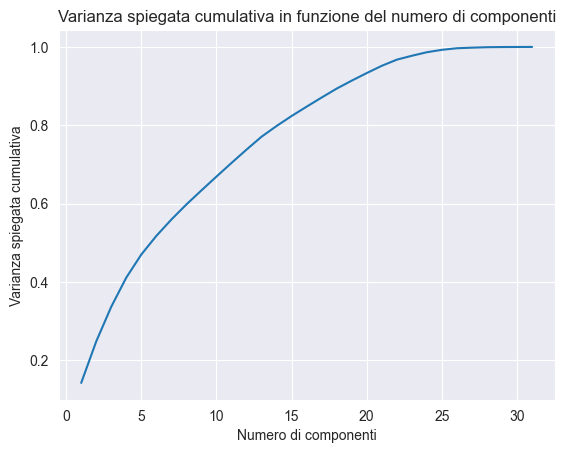

In [21]:
# PCA senza riduzione di dimensioni
pca = PCA()
core_users_pca = pca.fit(core_users_standardized)

# Calcola la varianza spiegata cumulativa
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualizza la varianza spiegata cumulativa
plt.plot(range(1,len(explained_variance)+1), explained_variance)
plt.title('Varianza spiegata cumulativa in funzione del numero di componenti')
plt.xlabel('Numero di componenti')
plt.ylabel('Varianza spiegata cumulativa')
plt.show()


# pca_calculation = [core_users_standardized_all, core_users_standardized_credibility, core_users_standardized_initiative, core_users_standardized_adaptability]
# core_users_pca = []
# 
# for i in range(len(pca_calculation)):
#     pca = PCA()
#     core_users_pca.append(pca.fit(pca_calculation[i]))
# 
#     # Calcola la varianza spiegata cumulativa
#     explained_variance = np.cumsum(pca.explained_variance_ratio_)
# 
#     # Visualizza la varianza spiegata cumulativa
#     plt.plot(range(1,len(explained_variance)+1), explained_variance)
#     plt.title('Varianza spiegata cumulativa in funzione del numero di componenti')
#     plt.xlabel('Numero di componenti')
#     plt.ylabel('Varianza spiegata cumulativa')
#     plt.show()
    

Applicazione della PCA per ridurre le dimensioni del dataset e utilizzo dell'Eblow Method per determinare il numero di cluster da utilizzare.

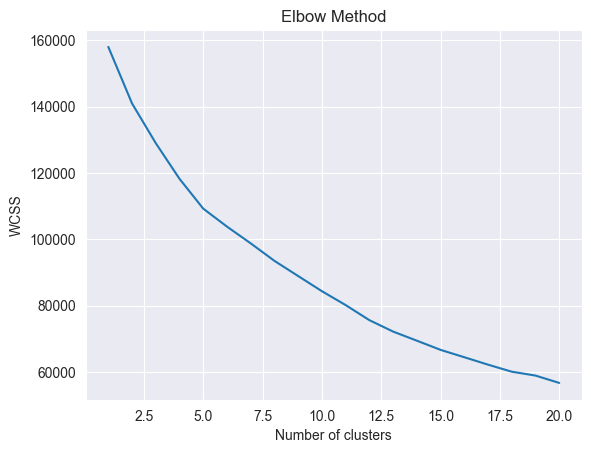

In [22]:
# Applica PCA
pca = PCA(n_components=14)
core_users_pca = pca.fit_transform(core_users_standardized)

# Calcola la WCSS per diverse quantità di cluster
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=0).fit(core_users_pca)
    wcss.append(kmeans.inertia_)

# Visualizza la WCSS in funzione del numero di cluster
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



# wcss_calculation = [core_users_standardized_all, core_users_standardized_credibility, core_users_standardized_initiative, core_users_standardized_adaptability]
# core_users_pca = []
# n_components = [2, 2, 2, 2]
# 
# for i in range(len(wcss_calculation)):
#     # Applica PCA
#     pca = PCA(n_components=n_components[i])
#     current_pca = pca.fit_transform(wcss_calculation[i])
#     core_users_pca.append(current_pca)  # Salva la matrice PCA nella lista
# 
#     # Calcola la WCSS per diverse quantità di cluster
#     wcss = []
#     for j in range(1, 21):
#         kmeans = KMeans(n_clusters=j, n_init=20, random_state=0).fit(current_pca)
#         wcss.append(kmeans.inertia_)
# 
#     # Visualizza la WCSS in funzione del numero di cluster
#     plt.plot(range(1, 21), wcss)
#     plt.title('Elbow Method')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('WCSS')
#     plt.show()

## K-Means algorithm

C:\Users\davis\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


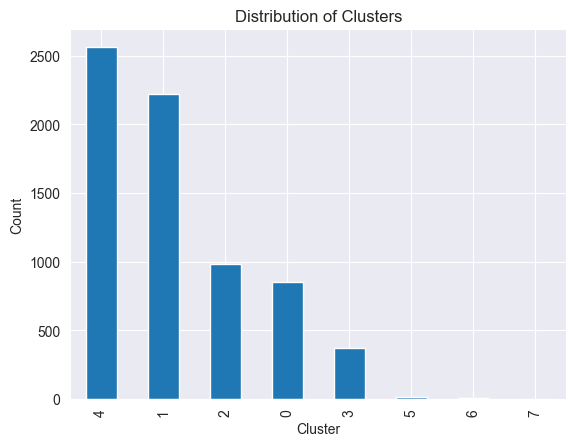

In [23]:
# Esegui il clustering K-means
kmeans = KMeans(n_clusters=8, random_state=0).fit(core_users_pca)

# Aggiungi le etichette dei cluster ai dati
core_users_clustered['kmeans_cluster'] = kmeans.labels_

# Visualizza la distribuzione dei cluster
core_users_clustered['kmeans_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()



# n_clusters = [5, 5, 4, 5]
# labels = ['all', 'credibility', 'initiative', 'adaptability']
# 
# for i in range(len(core_users_pca)):
#     # Esegui il clustering K-means
#     kmeans = KMeans(n_clusters=n_clusters[i], random_state=0).fit(core_users_pca[i])
#     
#     # Crea il nome della colonna dinamicamente
#     column_name = 'kmeans_cluster_' + labels[i]
# 
#     # Aggiungi le etichette dei cluster ai dati
#     core_users_clustered[column_name] = kmeans.labels_
# 
#     # Visualizza la distribuzione dei cluster
#     core_users_clustered[column_name].value_counts().plot(kind='bar')
#     plt.xlabel('Cluster')
#     plt.ylabel('Count')
#     plt.title('Distribution of Clusters for ' + labels[i])
#     plt.show()


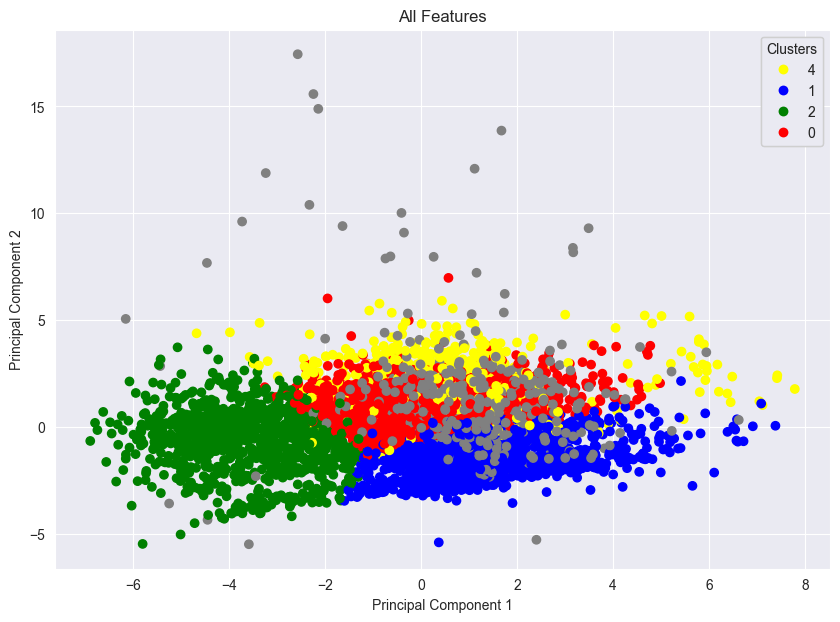

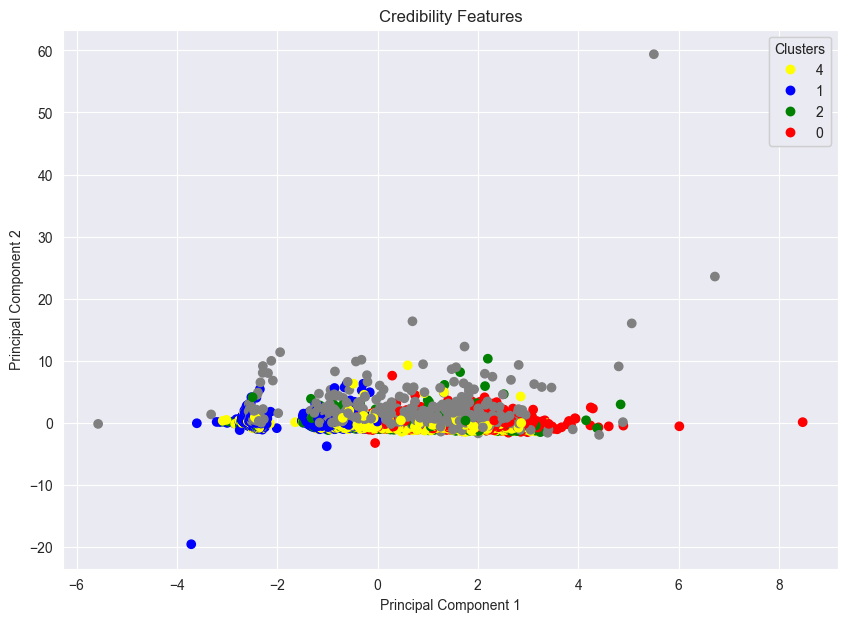

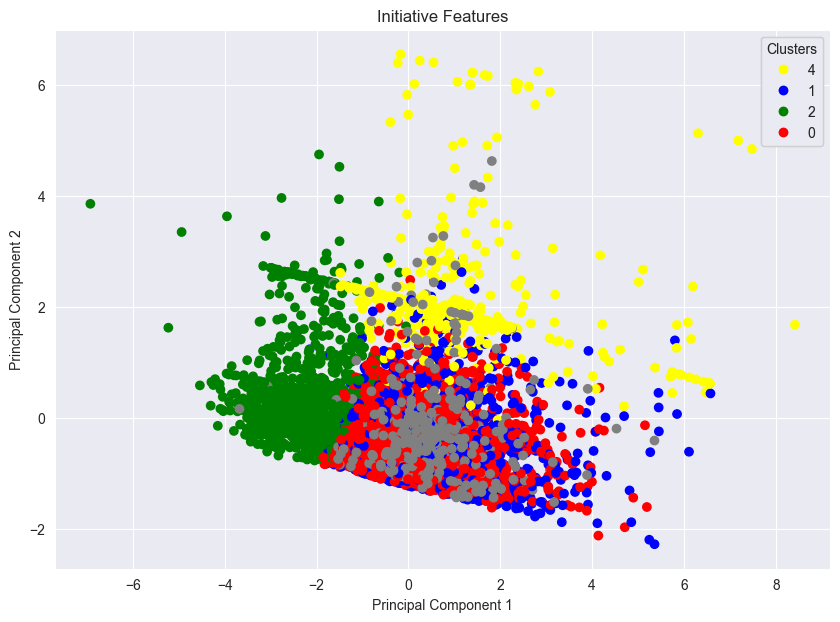

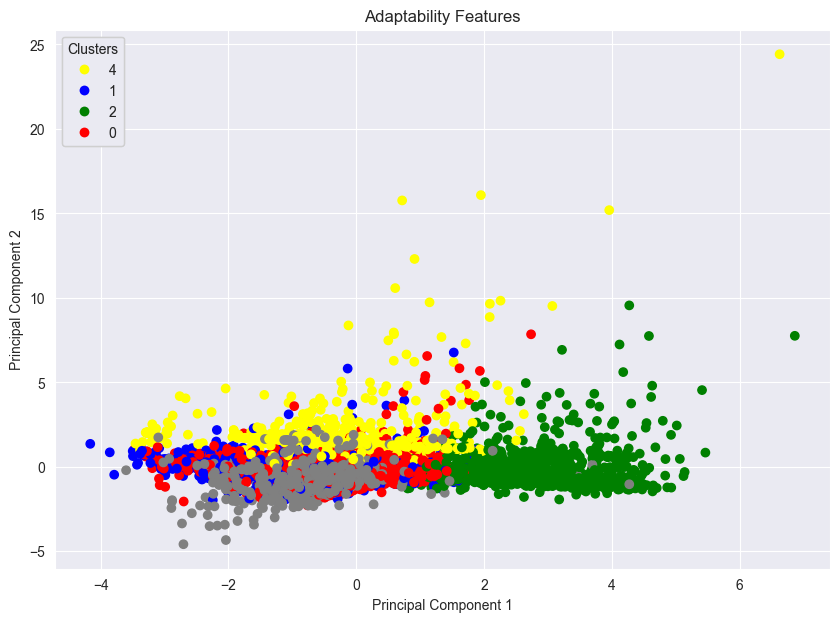

In [24]:
def plot_2D_PCA(data, labels, title):
    """Visualizza uno scatter plot 2D dei dati PCA"""    
    plt.figure(figsize=(10, 7))
    
    # Creo un nuovo array di etichette
    grey_labels = np.full_like(labels, -1)
    
    # Coloro in modo distintivo solo i cluster 4, 1, 2 e 0
    for cluster in [4, 1, 2, 0]:
        grey_labels[labels == cluster] = cluster
    
    # Creo una mappa di colori personalizzata
    colors = ['grey', 'yellow', 'blue', 'green', 'red']  # Aggiungi altri colori se necessario
    cmap = ListedColormap(colors)
    
    scatter = plt.scatter(data[:, 0], data[:, 1], c=grey_labels, cmap=cmap)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    # plt.gca().add_artist(legend1)
    
    # Creo una legenda con solo i cluster desiderati
    handles, _ = scatter.legend_elements()
    new_handles = [handles[i] for i in [1, 2, 3, 4]]  # Seleziona solo i marker per i cluster 4, 1, 2 e 0
    legend1 = plt.legend(new_handles, ['4', '1', '2', '0'], title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title(title)
    plt.show()

# Per ogni gruppo di feature
for title, features in feature_groups.items():
    subset = core_users_standardized[features]

    # Applica PCA con 2 componenti
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset)

    # Visualizza lo scatter plot
    plot_2D_PCA(pca_result, core_users_clustered['kmeans_cluster'].values, title)


## DBSCAN algorithm

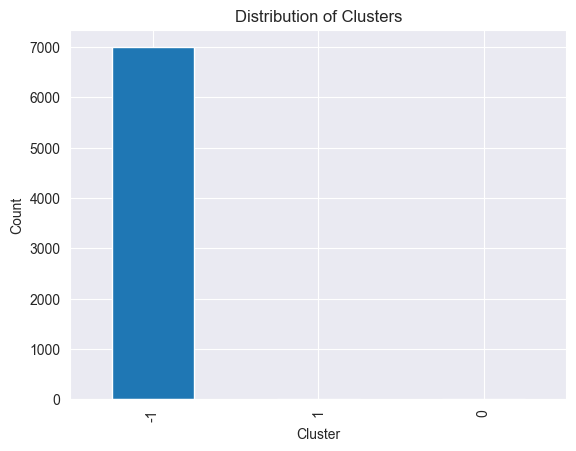

In [25]:
# Eseguiamo DBSCAN sui dati
db = DBSCAN(eps=0.4, min_samples=8).fit(core_users_pca)

# Aggiungi le etichette dei cluster ai dati
core_users_clustered['db_cluster'] = db.labels_

# Visualizza la distribuzione dei cluster
core_users_clustered['db_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()



# labels = ['all', 'credibility', 'initiative', 'adaptability']
# 
# for i in range(len(core_users_pca)):
#     # Eseguiamo DBSCAN sui dati
#     db = DBSCAN(eps=0.3, min_samples=8).fit(core_users_pca[i])
#     
#     # Crea il nome della colonna dinamicamente
#     column_name = 'db_cluster_' + labels[i]
#     
#     # Aggiungi le etichette dei cluster ai dati
#     core_users_clustered[column_name] = db.labels_
#     
#     # Visualizza la distribuzione dei cluster
#     core_users_clustered[column_name].value_counts().plot(kind='bar')
#     plt.xlabel('Cluster')
#     plt.ylabel('Count')
#     plt.title('Distribution of Clusters')
#     plt.show()


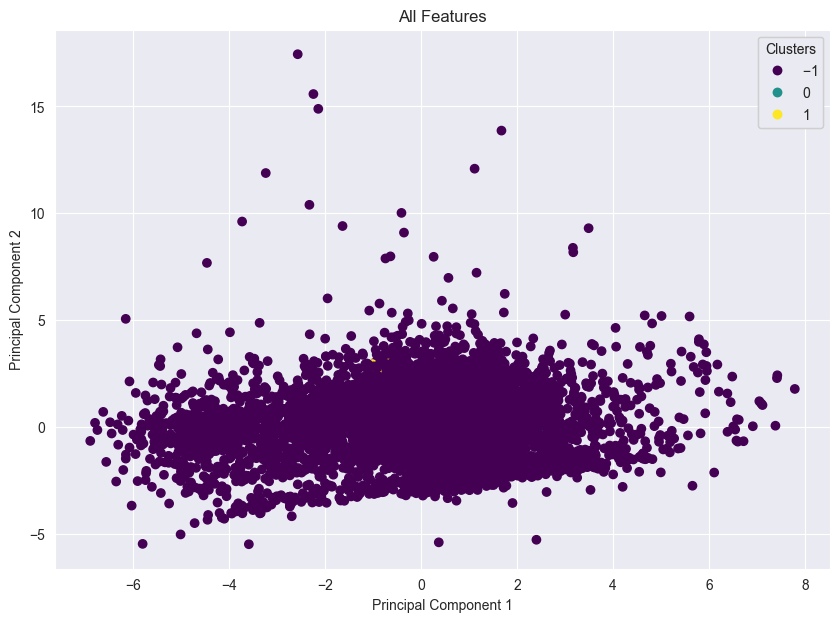

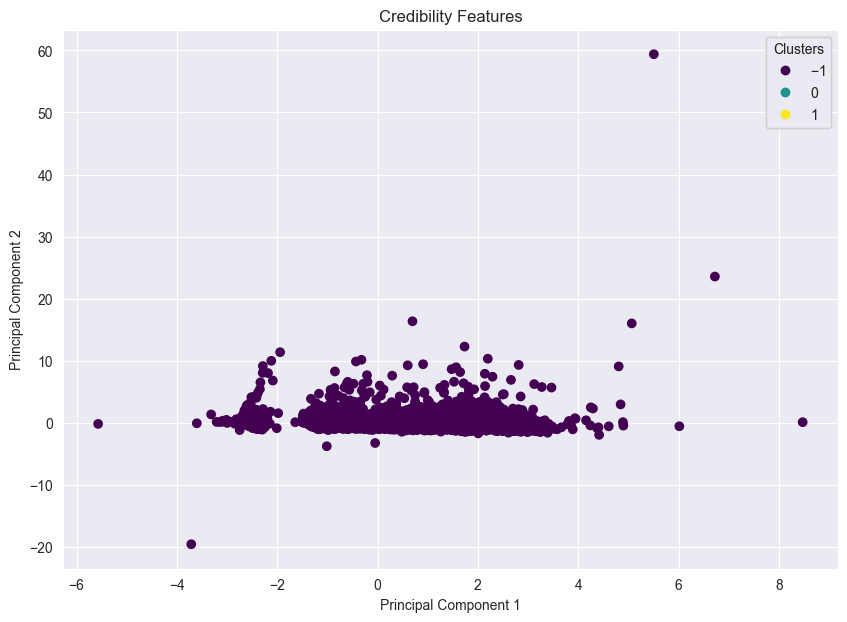

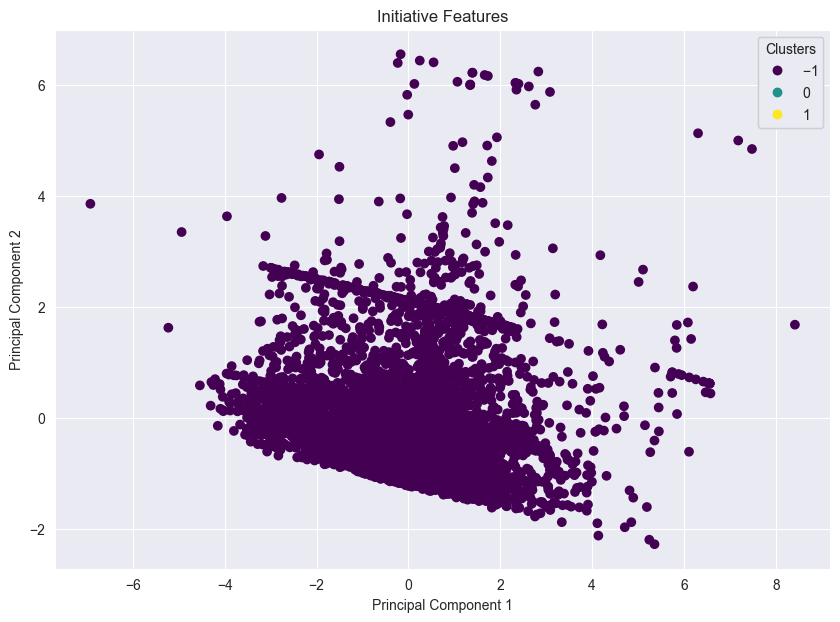

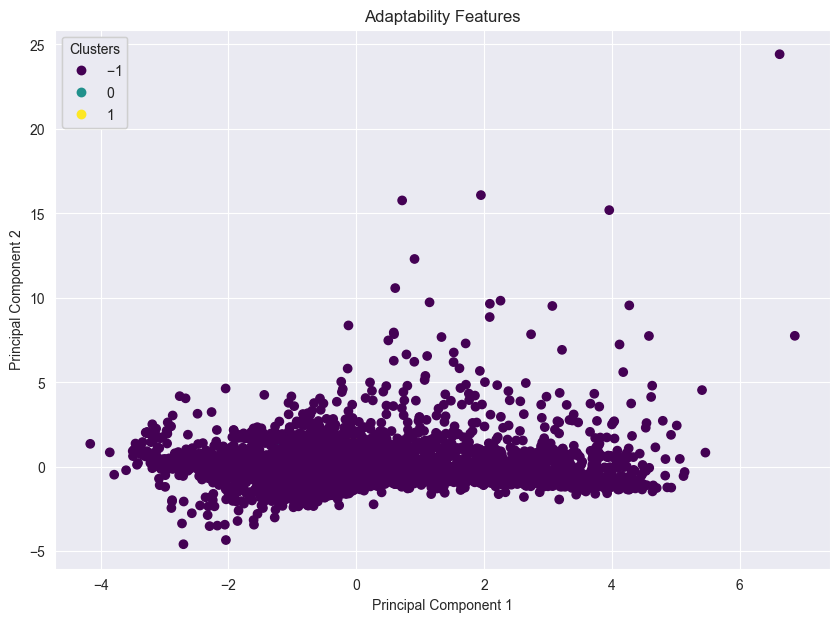

In [26]:
def plot_2D_PCA(data, labels, title):
    """Visualizza uno scatter plot 2D dei dati PCA"""    
    plt.figure(figsize=(10, 7))
    
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title(title)
    plt.show()

# Per ogni gruppo di feature
for title, features in feature_groups.items():
    subset = core_users_standardized[features]

    # Applica PCA con 2 componenti
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset)

    # Visualizza lo scatter plot
    plot_2D_PCA(pca_result, core_users_clustered['db_cluster'].values, title)


## HDBSCAN algorithm

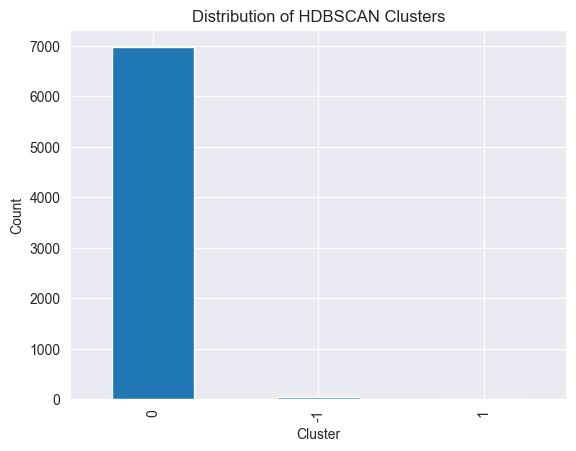

In [27]:
# Creiamo l'istanza di HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=5)

# Facciamo il fit su core_users_pca[0]
hdbscan_labels = hdbscan.fit_predict(core_users_pca)

# Aggiungiamo le etichette dei cluster ai dati
core_users_clustered['hdbscan_cluster'] = hdbscan_labels


# Visualizza la distribuzione dei cluster HDBSCAN
core_users_clustered['hdbscan_cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of HDBSCAN Clusters')
plt.show()



# labels = ['all', 'credibility', 'initiative', 'adaptability']
# 
# for i in range(len(core_users_pca)):
#     # Eseguiamo DBSCAN sui dati
#     hdbscan = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True).fit(core_users_pca[i])
#     
#     # Crea il nome della colonna dinamicamente
#     column_name = 'hdbscan_cluster_' + labels[i]
#     
#     # Aggiungi le etichette dei cluster ai dati
#     core_users_clustered[column_name] = hdbscan.labels_
#     
#     # Visualizza la distribuzione dei cluster
#     core_users_clustered[column_name].value_counts().plot(kind='bar')
#     plt.xlabel('Cluster')
#     plt.ylabel('Count')
#     plt.title('Distribution of Clusters')
#     plt.show()


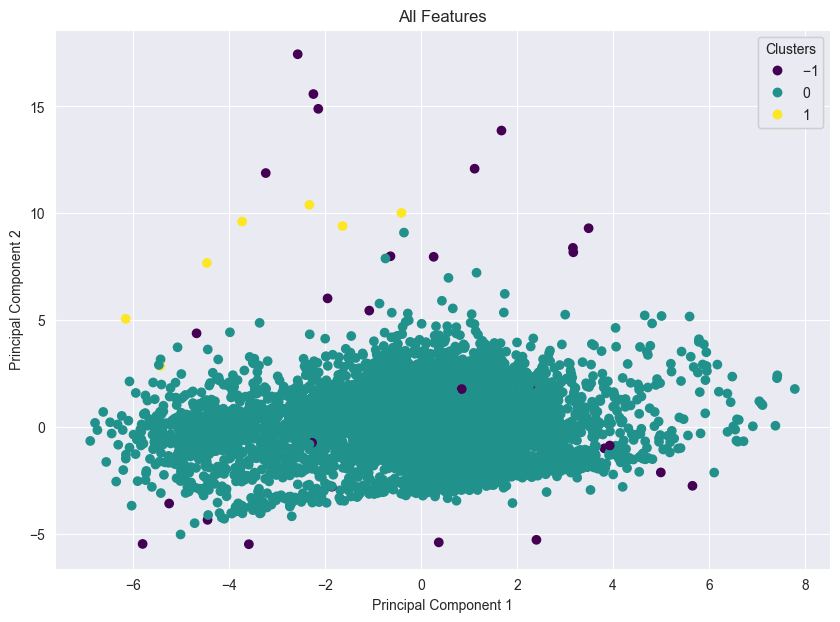

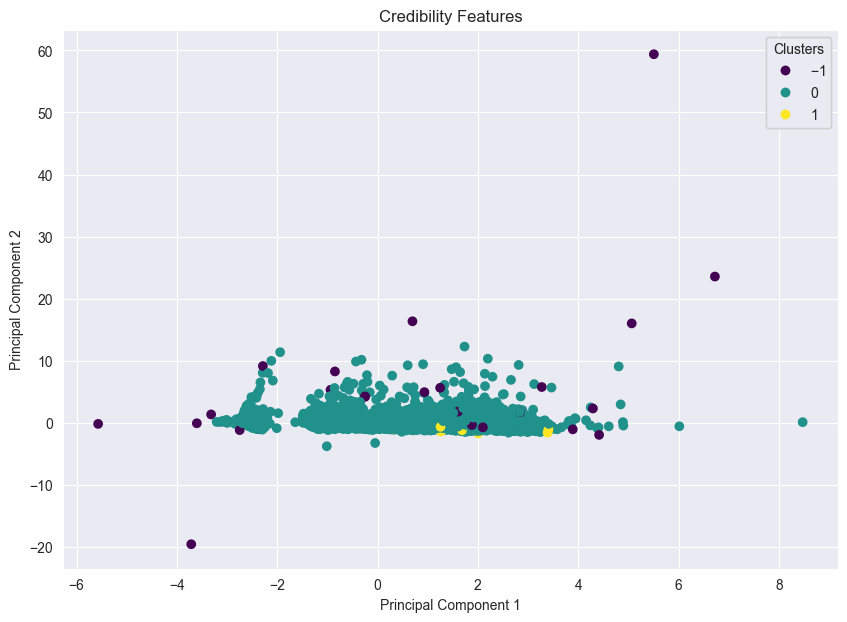

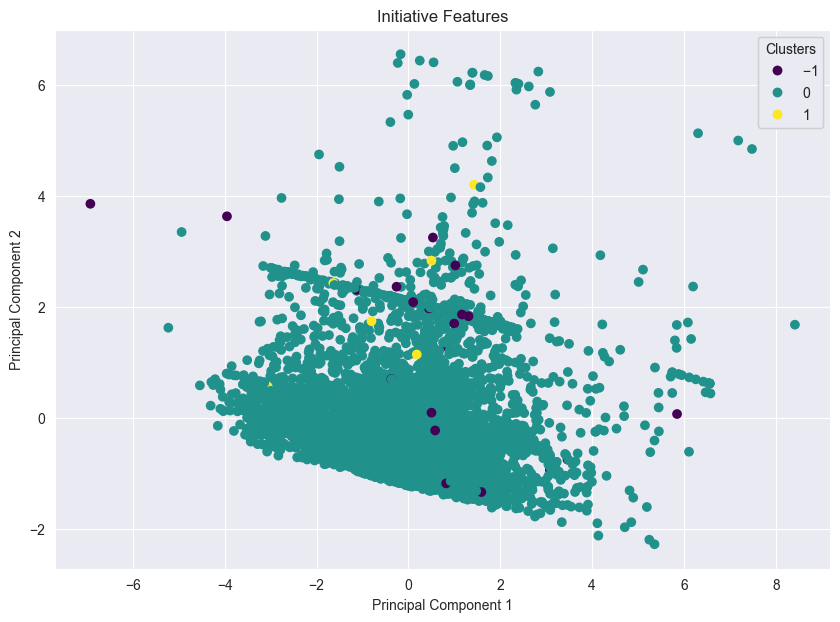

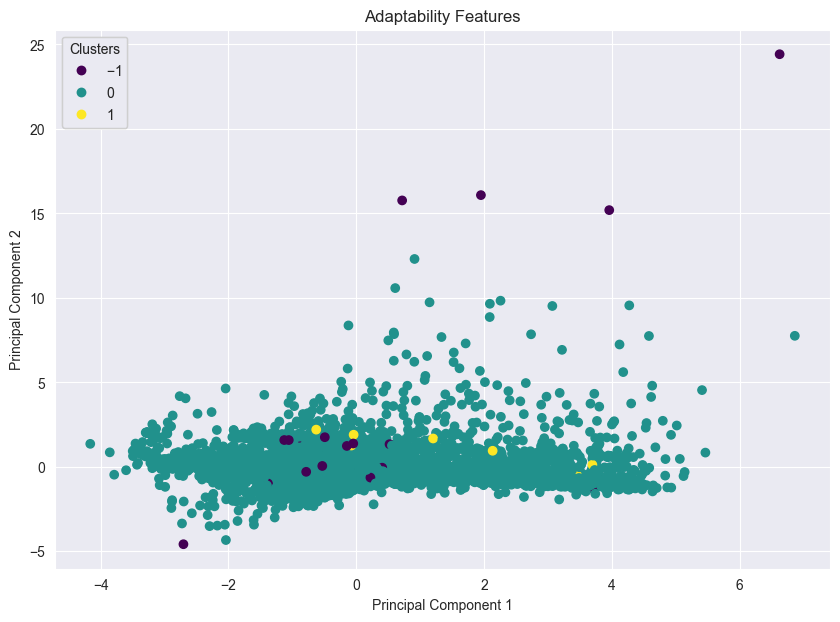

In [28]:
def plot_2D_PCA(data, labels, title):
    """Visualizza uno scatter plot 2D dei dati PCA"""    
    plt.figure(figsize=(10, 7))
    
    scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.gca().add_artist(legend1)
    
    plt.title(title)
    plt.show()

# Per ogni gruppo di feature
for title, features in feature_groups.items():
    subset = core_users_standardized[features]

    # Applica PCA con 2 componenti
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset)

    # Visualizza lo scatter plot
    plot_2D_PCA(pca_result, core_users_clustered['hdbscan_cluster'].values, title)


## Data Saving

In [29]:
core_users_clustered.to_csv('../data/core_users_clustered.csv', index=False)

## Random Forest Classifier

In [ ]:
# Divisione del dataset in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(
    core_users_standardized,
    core_users_clustered['kmeans_cluster'],
    test_size=0.30,
    random_state=42
)

# Creazione e addestramento del modello
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Previsioni sul set di test
y_pred = rf.predict(X_test)

# Stampa del classification report
print(classification_report(y_test, y_pred))


## SHAPE Values

In [ ]:
# Crea un "explainer" SHAP usando il modello Random Forest
explainer = shap.TreeExplainer(rf)

# Calcola i valori SHAP per ogni feature
shap_values = explainer.shap_values(core_users_standardized)


# Visualizza i valori SHAP
shap.summary_plot(shap_values, core_users_standardized)


### Individual SHAP Value Plot (o Force Plot)

*   Voce elencoQuesto grafico mostra l'effetto di ciascuna feature sull'output del modello per una singola osservazione (un singolo punto dati nel tuo dataset).
* Il plot è costituito da una barra orizzontale dove il punto di partenza rappresenta il valore atteso (la media delle previsioni sul dataset), e la freccia punta al valore effettivamente predetto per quella osservazione.
* Ogni feature contribuisce a spostare il valore della previsione partendo dal valore atteso: le feature che aumentano il valore della previsione sono mostrate in rosso, mentre quelle che lo diminuiscono sono mostrate in blu.
* Interpretazione: Ad esempio, se il plot mostra che la feature 'X' ha un impatto positivo significativo su un dato punto, significa che, per quella specifica osservazione, il valore di 'X' ha contribuito a incrementare il risultato del modello.

In [ ]:
shap.initjs()
i = 0  # Index of the sample
shap.force_plot(explainer.expected_value[0], shap_values[0][i], core_users_standardized.iloc[i])


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], core_users_standardized)


### SHAP Dependence Plot

* Questo grafico mostra la relazione tra i valori di una singola feature e gli effetti SHAP di quella feature attraverso tutto il dataset.
* In pratica, mostra come cambia l'importanza di una specifica feature al variare del suo valore.
* L'asse delle ordinate rappresenta il valore SHAP della feature, mentre l'asse delle ascisse rappresenta il valore reale della feature.
* I punti colorati rappresentano il valore di una terza feature, che aiuta a visualizzare potenziali interazioni tra features.
* Interpretazione: Ad esempio, se il grafico mostra una tendenza positiva, significa che quando il valore della feature aumenta, anche il suo effetto positivo sulla previsione aumenta, e viceversa.

In [ ]:
shap.dependence_plot(bio_characters, shap_values[0], core_users_standardized)


### Waterfall Plot

* Questo grafico è usato per visualizzare le contribuzioni di ciascuna feature alla previsione per una singola osservazione.
* Parte dal valore atteso (la media delle previsioni sul dataset) e aggiunge iterativamente l'effetto di ciascuna feature.
* Le barre colorate mostrano l'effetto di ciascuna feature sulla previsione: le barre in rosso indicano un effetto positivo (hanno aumentato la previsione), mentre le barre in blu indicano un effetto negativo (hanno diminuito la previsione).
* Interpretazione: Ti permette di vedere in modo chiaro e sequenziale come ciascuna feature ha modificato la previsione partendo dal valore atteso fino al valore predetto finale per quella specifica osservazione.

In [ ]:
i = 0  # Index of the sample
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][i], feature_names=core_users_standardized.columns)
